In [55]:
# Load the usual suspects:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)


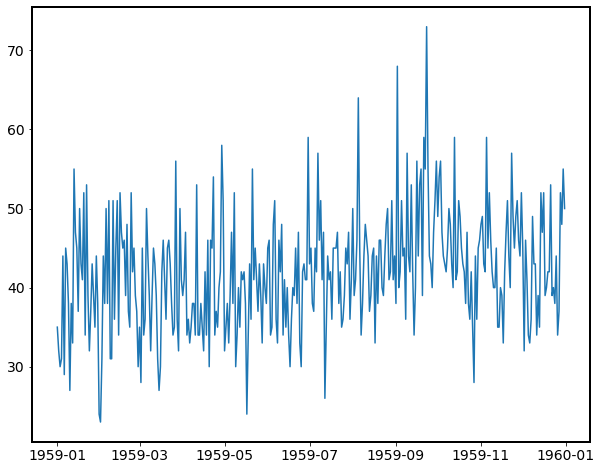

In [56]:
daily_female = pd.read_csv('daily-total-female-births-in-cal.csv')
daily_female['Date'] = pd.to_datetime(daily_female['Date'] )
daily_female = daily_female.set_index('Date')
daily_female
data = daily_female.copy()
plt.plot(data)

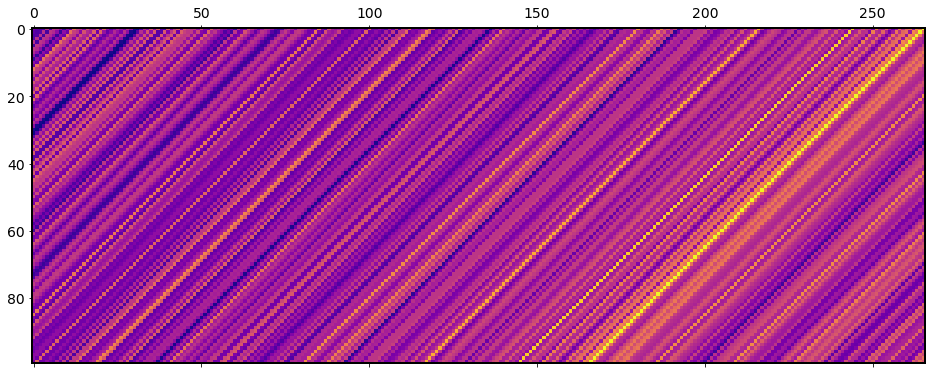

In [57]:
N = len(data)
L = 100 # The window length.
K = N - L + 1 

### Создание матрицы Генкеля
X = np.column_stack([daily_female[i:i+L] for i in range(0,K)])
plt.matshow(X)

In [58]:
d = np.linalg.matrix_rank(X) 

U, Sigma, V = np.linalg.svd(X)
V = V.T
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

In [44]:
def Hankelise(X):
    """
    Hankelises the matrix X, returning H(X).
    """
    L, K = X.shape
    transpose = False
    if L > K:
        # The Hankelisation below only works for matrices where L < K.
        # To Hankelise a L > K matrix, first swap L and K and tranpose X.
        # Set flag for HX to be transposed before returning. 
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))
    
    # I know this isn't very efficient...
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]    
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX

In [45]:
def X_to_TS(X_i):
    """Усредняет антидиагонали заданной элементарной матрицы X_i и возвращает временной ряд"""
    # Обратный порядок столбцов X_i
    X_rev = X_i[::-1]
    
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    
    
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

100


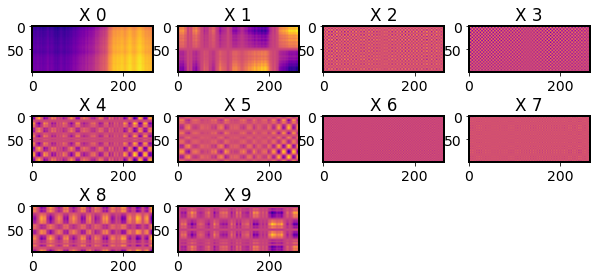

In [59]:
print(len(X_elem))
for i in range(10):
    plt.subplot(5,4,i+1)
    plt.imshow(X_elem[i])
    title = f'X {i}'
    plt.title(title)

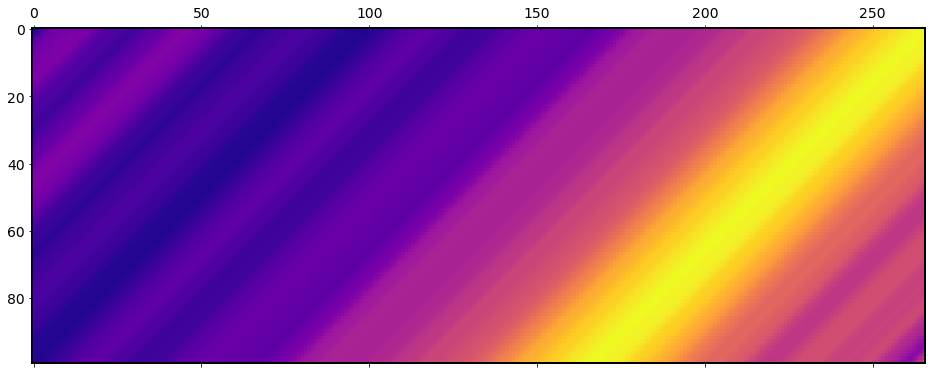

In [47]:
### посмотрим, что будет, если обьединить самые заметные элементарные матрциы
pred = 0
for i in [0,1,9]:
    pred+=Hankelise(X_elem[i])
plt.matshow(pred)

100


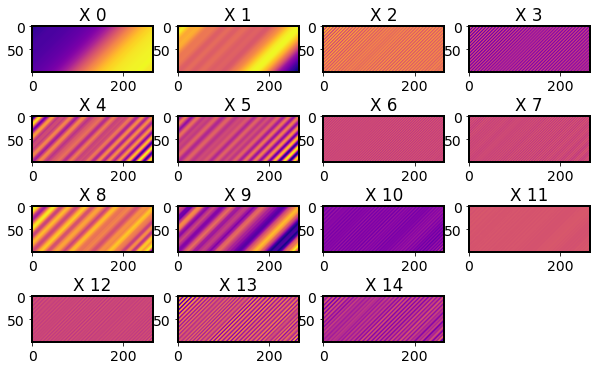

In [60]:
### посмотрим на генкелизованные матрицы
print(len(X_elem))
for i in range(15):
    plt.subplot(5,4,i+1)
    plt.imshow(Hankelise(X_elem[i]))
    title = f'X {i}'
    plt.title(title)

* Теперь нам нужно понять, какие группы матриц создать


In [61]:
w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])
F_elem = np.array([X_to_TS(X_elem[i]) for i in range(d)])


In [62]:
F_wnorms = np.array([w.dot(F_elem[i]**2) for i in range(d)])
F_wnorms
F_wnorms = F_wnorms**-0.5

In [63]:

Wcorr = np.identity(d)
for i in range(d):
    for j in range(i+1,d):
        Wcorr[i,j] = abs(w.dot(F_elem[i]*F_elem[j]) * F_wnorms[i] * F_wnorms[j])
        Wcorr[j,i] = Wcorr[i,j]

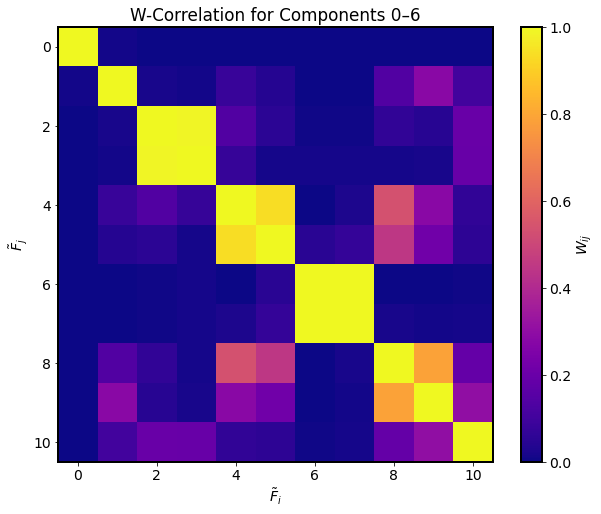

In [64]:
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.xlim(-0.5,10.5)
plt.ylim(10.5,-0.5)
plt.clim(0,1)
plt.title(r"W-Correlation for Components 0–6");

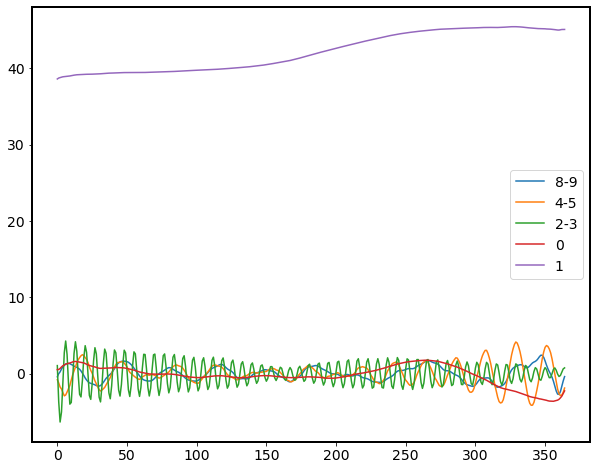

In [65]:
### Итоговое представление времянного ряда
x_9_8 = X_to_TS(X_elem[9]+X_elem[8])
x_5_4 = X_to_TS(X_elem[5]+X_elem[4])
x_3_2 = X_to_TS(X_elem[3]+X_elem[2])

x_0=X_to_TS(X_elem[1])
x_1=X_to_TS(X_elem[0])

plt.plot(x_9_8,label='8-9')
plt.plot(x_5_4,label='4-5')
plt.plot(x_3_2,label='2-3')
plt.plot(x_0,label='0')
plt.plot(x_1,label='1')
plt.legend()